In [1]:
%matplotlib inline

import ipykernel
import numpy as np
from astropy.io import fits
import astropy.units as units
from astropy.coordinates import SkyCoord
import matplotlib.pyplot as plt
from scipy import stats
from matplotlib import rc
from scipy.interpolate import interp1d, interp2d
from scipy import stats
from matplotlib.colors import LogNorm
from scipy.integrate import simps, trapz
                                                                                                                                                                                                                                

from scipy import sparse
from sklearn.mixture import GMM

from statsmodels.nonparametric.smoothers_lowess import lowess

In [2]:
rc('text', usetex= True)
rc('font', family='serif', weight = 'normal', size=20)


This notebook is very similar to bayesIsoFit_prlxConst, where the steps are better explained. 
The procedure is basically the same, we only added a uniform prior to the parallax, then we marginalized on the parallax and compute a new 'G' function. In any case see Jorgensen and Lindegren (2005) for the details of the method.



Isochrones

In [3]:
isochrone2MASS = '../IsoFit/padovaJHKAv025Z002.fits'
isochroneGaia = '../IsoFit/padovaGaiaAv025Z002.fits'

photo2MASS = fits.open(isochrone2MASS)
photo2MASS = photo2MASS[1].data
photoGaia = fits.open(isochroneGaia)
photoGaia = photoGaia[1].data 

Data

In [5]:
hdu = fits.open('/data1/Data/Zari+17/gaia_inside_contour.fits')
data = hdu[1].data

In [6]:
flux_error =  data['phot_g_mean_flux_error']
flux = data['phot_g_mean_flux']
Gmag = data['phot_g_mean_mag']
Jmag = data['j_m']
G0=25.525
sigmaG0 = 0.003
sigmaGmag = np.sqrt((1.0857*(flux_error/flux))**2. + sigmaG0**2.)
sigmaJ = data['j_msigcom']
sigmaGminj = np.sqrt(sigmaGmag**2. + sigmaJ**2.) 

In [10]:
ages = np.arange(6., 8.5, 0.01)
gminj = Gmag-Jmag
gfSmoothAll, gfAll = determineClusterAge(Gmag, sigmaGmag, gminj, sigmaGminj,
                                             isochrone2MASS, isochroneGaia, ages)

0 6.0 214
1 6.01 217
2 6.02 214
3 6.03 210
4 6.04 208
5 6.05 224
6 6.06 221
7 6.07 223
8 6.08 222
9 6.09 211
10 6.1 210
11 6.11 209
12 6.12 217
13 6.13 224
14 6.14 222
15 6.15 220
16 6.16 224
17 6.17 217
18 6.18 218
19 6.19 220
20 6.2 213
21 6.21 221
22 6.22 228
23 6.23 234
24 6.24 225
25 6.25 221
26 6.26 229
27 6.27 230
28 6.28 229
29 6.29 237
30 6.3 240
31 6.31 240
32 6.32 231
33 6.33 231
34 6.34 236
35 6.35 245
36 6.36 244
37 6.37 273
38 6.38 266
39 6.39 273
40 6.4 280
41 6.41 290
42 6.42 292
43 6.43 305
44 6.44 329
45 6.45 333
46 6.46 327
47 6.47 333
48 6.48 328
49 6.49 372
50 6.5 367
51 6.51 358
52 6.52 381
53 6.53 379
54 6.54 372
55 6.55 365
56 6.56 370
57 6.57 367
58 6.58 359
59 6.59 351
60 6.6 376
61 6.61 389
62 6.62 395
63 6.63 389
64 6.64 385
65 6.65 387
66 6.66 356
67 6.67 334
68 6.68 294
69 6.69 297
70 6.7 331
71 6.71 329
72 6.72 337
73 6.73 325
74 6.74 295
75 6.75 280
76 6.76 273
77 6.77 277
78 6.78 278
79 6.79 260
80 6.8 269
81 6.81 260
82 6.82 265
83 6.83 262
84 6.84 256

Compute Ages.

The age is defined as the maximum of the posterior.

In [57]:
ids = data['source_id']
singleAges = np.zeros(len(gfAll))
for i in range(len(gfAll)):
        try:
            singleAges[i] = ages[np.where(gfAll[i] == np.max(gfAll[i]))]
        except ValueError:
            print(ids[i])
            singleAges[i] = 0.


3217600657042809216
3215571955009382912
3215584466249609088
3218584067113828608
2999260737509766784
2998821482615015680
2998799148785080320
2998752763137080064
3017372030480935424
3017182089847721088
3017229712445225344
3216041034158671360
3016484724597615744
3209592123584617216
3011933914689254656
3022725586956452608
3011151818325178752
3011993597555201792
3011130961963752448
3001438320288905344
3011024687292833152
3012753634967547008
3010859794908791552
3011202876896541952
3011518574172797056
3011294995355071616
3023408624195762048
3023502495001097472
3022269667588699520
3024164091762617984
3220339506147310208
3023340145237048064
3023083546710942464
3220687673376726656
3220281472548574208
3023209887468532224
2999021971688230272
3022228504621299712
3024577576855796224
2999040319788670080
2999062413099249664
3218623374654864384
2999081036078534272
3218801255021255040
3218940892998062976
3218804862793810688
3218822248821293568
3218867844194186624
3218592416530714368
3218649522416013184


In [18]:
gfNorm = np.zeros((len(gfAll), len(ages)))
for i in range(len(gfAll)):
    
    indx = np.where(gfAll[i] == np.max(gfAll[i]))
    ### Use numerical precision to exclude stars with very small posteriors
    t = 10**-15
    
    if (gfAll[i, indx][0,0]) >= t:
        gfNorm[i, :] = gfAll[i, :]/np.max(gfAll[i, :])
    else: 
        gfNorm[i, :] = 0.
        
indxGood,  indxBad = computeGoodG(gfNorm, ages, ids)


Value Error at star: 2999104817312958592
Value Error at star: 3215584466249609088
Value Error at star: 3015775990569271168
Value Error at star: 3012639874169246464
Value Error at star: 2999001562003300480
Value Error at star: 3217576575160784256
Value Error at star: 3217069970882090496
Value Error at star: 3216960706915183360
Value Error at star: 3217344402112419712
Value Error at star: 3216972835901783168
Value Error at star: 3215822746739865216
Value Error at star: 3218555067493790976
Value Error at star: 3218682782641298944
Value Error at star: 3216753552052508672
Value Error at star: 3218568295993056640
Value Error at star: 3215837693226051712
Value Error at star: 3217123228478404224
Value Error at star: 3216914286908669568
Value Error at star: 3216729878197029120
Value Error at star: 3215766980884499200
Value Error at star: 3217170026440200576
Value Error at star: 3215866452326995968
Value Error at star: 3216918891113603968
Value Error at star: 3217694081171057152
Value Error at s

Value Error at star: 3011132439432112512
Value Error at star: 3011069904708657024
Value Error at star: 3001438389008368768
Value Error at star: 3010893368667531136
Value Error at star: 3011152058843269376
Value Error at star: 3011184288277308288
Value Error at star: 3001445398394990848
Value Error at star: 3010870308988021120
Value Error at star: 3011187969064531840
Value Error at star: 3011221671672921344
Value Error at star: 3011253282632216064
Value Error at star: 3010827256235844608
Value Error at star: 3023603237754080128
Value Error at star: 3024378290372515328
Value Error at star: 3011259158147478272
Value Error at star: 3024250987540906240
Value Error at star: 3011147901314675584
Value Error at star: 3011182570290936832
Value Error at star: 3011599525715589632
Value Error at star: 3010818597581779584
Value Error at star: 3011615125036807808
Value Error at star: 3011215349481650944
Value Error at star: 3011321658511975424
Value Error at star: 3011530600080431360
Value Error at s

Save

In [60]:
### Save in a .fits file 
### Note the format of the source id!

path = '/data1/Data/Zari+17/'
filename = 'bayesAgeEstimate_prlxUnifPrior_Good.fits'

colAges = fits.Column(name='ages', format='D', array= singleAges[indxGood])
colL = fits.Column(name='l', format='D', array= data['l'][indxGood])
colB = fits.Column(name='b', format='D', array= data['b'][indxGood])
colID  = fits.Column(name='sourceId', format='K', array= data['source_id'][indxGood])

cols = fits.ColDefs([colL, colB, 
                     colID, colAges])
tbhdu = fits.BinTableHDU.from_columns(cols)
tbhdu.writeto(path + filename)

filename = 'bayesAgeEstimate_prlxUnifPrior_Bad.fits'

colAges = fits.Column(name='ages', format='D', array= singleAges[indxBad])
colL = fits.Column(name='l', format='D', array= data['l'][indxBad])
colB = fits.Column(name='b', format='D', array= data['b'][indxBad])
colID  = fits.Column(name='sourceId', format='K', array= data['source_id'][indxBad])

cols = fits.ColDefs([colL, colB, 
                     colID, colAges])
tbhdu = fits.BinTableHDU.from_columns(cols)
tbhdu.writeto(path + filename)

Plot CMD

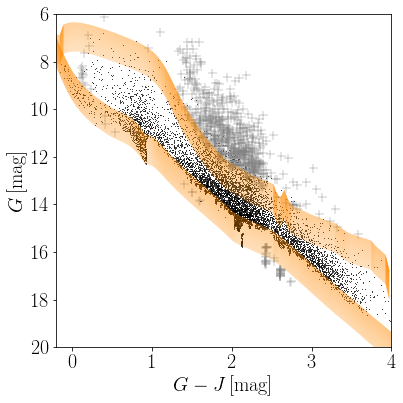

In [43]:
gminj = data['phot_g_mean_mag']-data['j_m']
gmag = data['phot_g_mean_mag']

plx = np.linspace(2., 3.5, 100)
d = 1000./plx
mu = 5*np.log10(d) - 5


plt.figure(figsize=(6, 6))
plt.plot(gminj[indxGood][singleAges[indxGood] <= 7.3],
         gmag[indxGood][singleAges[indxGood] <= 7.3],
         'ko', ms =0.8, markeredgecolor = 'None')
plt.plot(gminj[indxBad], gmag[indxBad], '+', color = 'gray',
         ms =9, mew = 0.4, alpha =1)
plt.axis([-0.2, 4., 20., 6])

isoage= [6., 7.3]
for a in isoage:
    
    if a == 6.:
        wG = [np.round(photoGaia['log(age/yr)'],3) == np.round(a,3)]
        wM = [np.round(photoGaia['log(age/yr)'],3) == np.round(a,3)]

        gmagI = photoGaia['G'][wG]
        jmagI = photo2MASS['J'][wM]
        gminjI = gmagI-jmagI
        
        
        for m in mu:
            xx = np.linspace(gminjI[gmagI>-3.].min(), gminjI[gmagI>-3].max(), 100)
            yy = interp1d(gminjI[gmagI > -3], gmagI[gmagI > -3])
            plt.plot(xx, yy(xx) + m, '-', color = 'DarkOrange', lw = 0.1)
    elif a==7.3:
        wG = [np.round(photoGaia['log(age/yr)'],3) == np.round(a,3)]
        wM = [np.round(photoGaia['log(age/yr)'],3) == np.round(a,3)]

        gmagI = photoGaia['G'][wG]
        jmagI = photo2MASS['J'][wM]
        gminjI = gmagI-jmagI
        
        xx = np.linspace(gminjI[gmagI>-3.].min(), gminjI[gmagI>-3].max(), 100)
        yy = interp1d(gminjI[gmagI > -3], gmagI[gmagI > -3])
        for m in mu:
            plt.plot(xx, yy(xx) + m, '-', color = 'DarkOrange', lw = 0.1)

plt.xlabel(r'$G-J \, \mathrm{[mag]}$', fontsize = 20)
plt.ylabel(r'$G \, \mathrm{[mag]}$', fontsize = 20)
plt.tight_layout()


Plot Age maps

In [62]:
### Read fits file

hduAges = fits.open('/data1/Data/Zari+17/bayesAgeEstimate_prlxUnifPrior_Good.fits')
dataAges = hduAges[1].data
l, b = dataAges['l'], dataAges['b']
singleAges = dataAges['ages']

In [64]:
ageBinsyrs = np.array([1.,3., 5., 7., 9., 11.,13,  15., 20., 200])*10**6.
ageBins = np.log10(ageBinsyrs)

In [71]:
from sklearn.neighbors import KernelDensity


lSel, bSel = dict(), dict()
sourceIdSel = dict()
singleAgesSel = dict()
log_dens_field = dict()


for i in range(len(ageBins)-1):
        w = np.where((singleAges >= ageBins[i]) & (singleAges < ageBins[i+1]))
        print(len(l[w]))
        lSel[i], bSel[i] = l[w], b[w]
        sourceIdSel[i] = sourceId[w]
        singleAgesSel[i] = singleAges[w]
        xmin, xmax = 190.,220.
        ymin, ymax = -30.,-5.

        X = np.vstack([lSel[i], bSel[i]]).T
        deg2rad = np.pi/180. 
        X = X*deg2rad
        kde = KernelDensity(kernel='gaussian', bandwidth=0.3*deg2rad, metric = 'haversine').fit(X)

        Xsamples = np.linspace(xmin, xmax, 300)
        Ysamples = np.linspace(ymin, ymax, 250)
        X,Y = np.meshgrid(Xsamples, Ysamples)
        grid = np.vstack([X.ravel(), Y.ravel()]).T
        grid = grid*deg2rad
        log_dens_field[i]= kde.score_samples(grid).T
        log_dens_field[i] = log_dens_field[i].reshape(X.shape)
    

2990
988
570
485
655
540
449
1334
15156


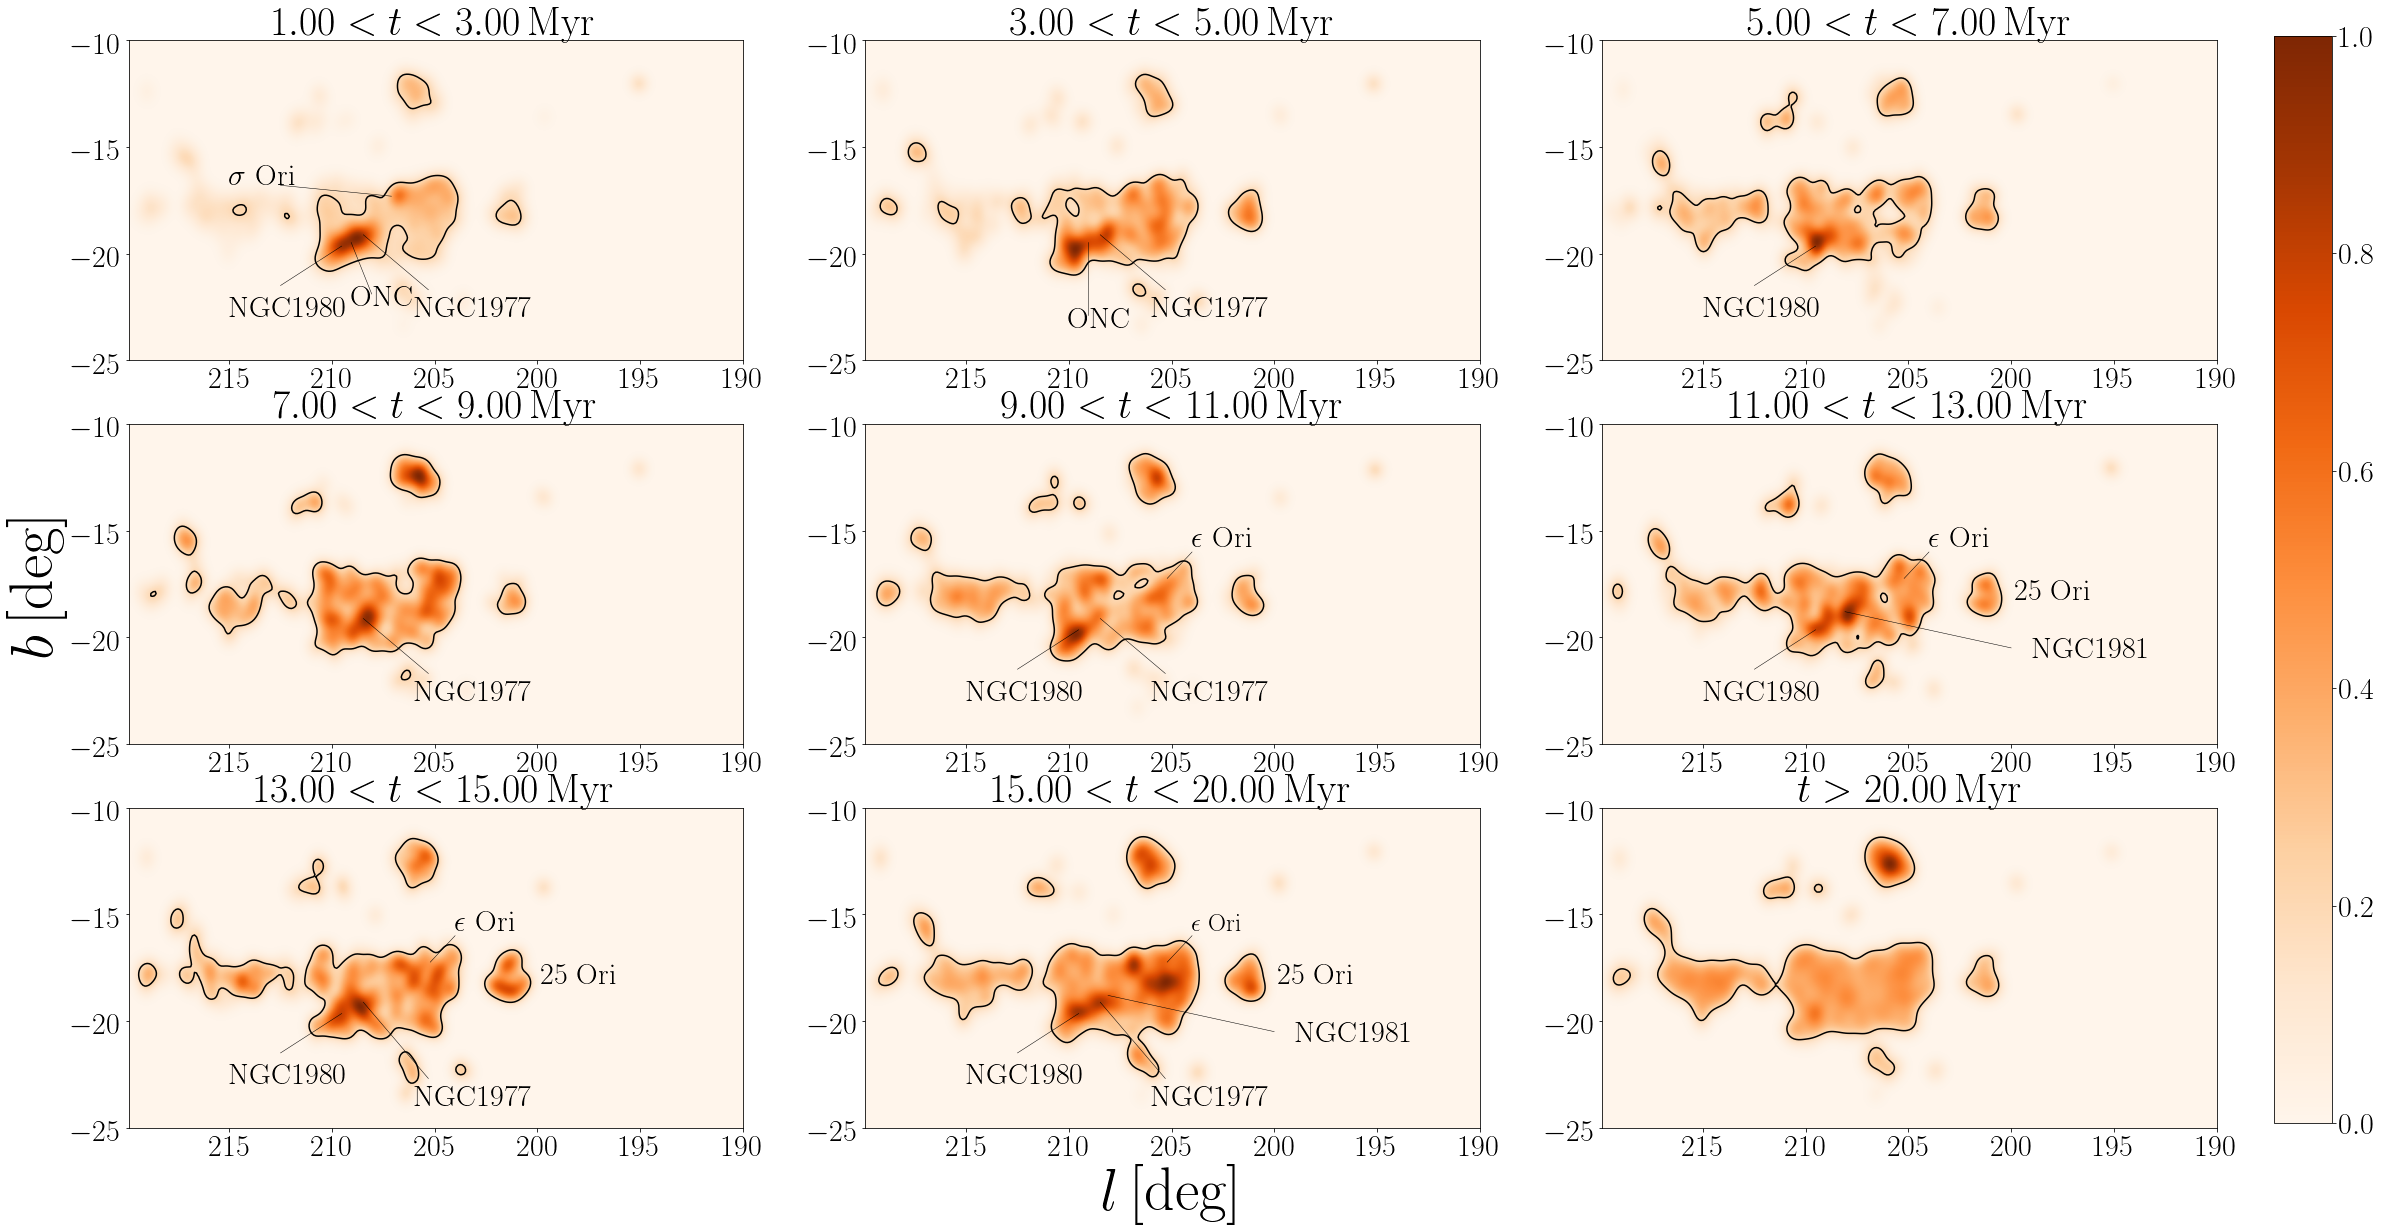

In [110]:
rc('font', family='serif', weight = 'normal', size=30)
xmin, xmax = 190., 220.
ymin, ymax = -30., -5.

fig = plt.figure(figsize=(40, 20))

for a in range(len(ageBins)-1):
    
    plt.subplot(3,3,a+1)
    im = plt.imshow(np.exp(log_dens_field[a])/np.max(np.exp(log_dens_field[a])),
                    extent = [xmin, xmax, ymin, ymax],
                    cmap=plt.cm.Oranges,
                    aspect = 'auto',
                    origin = 'lower', interpolation = 'gaussian')
    plt.contour(np.exp(log_dens_field[a])/np.max(np.exp(log_dens_field[a])),
            cmap = plt.cm.gray,
            extent=[xmin, xmax, ymin, ymax],
            levels = [0.2], lw = 1)
    
    if a == 3:
        plt.ylabel(r'$b \, \mathrm{[deg]}$', fontsize = 60)
    elif a == 7:
        plt.xlabel(r'$l \, \mathrm{[deg]}$', fontsize = 60)
    
    if a <= 7:
        plt.title(r' $%.2f < t  < %.2f \, \mathrm{Myr}$ ' %(10**ageBins[a]/10**6., 10**ageBins[a+1]/10**6), 
             fontsize = 40) 
    elif a ==8:
        plt.title(r' $ t  > %.2f \, \mathrm{Myr}$ ' %(10**ageBins[a]/10**6.), 
             fontsize = 40)     
        
    if a == 0:
        plt.text(215., -23., 'NGC1980', fontsize = 30, family ='sans-serif')
        plt.plot([212.5, 209.52], [-21.5, -19.65], 'k-', lw = 0.5)
        plt.text(209.06, -22.5, 'ONC', fontsize = 30, family ='sans-serif')
        plt.plot([208.06, 209.06], [-21.9, -19.48], 'k-', lw = 0.5)
        plt.text(215, -16.8, '$\mathrm{\sigma}$ Ori', fontsize = 30, family ='sans-serif')
        plt.plot([212.5, 207.1], [-16.8, -17.31], 'k-', lw = 0.5)
        #plt.text(196.5, -10.7 , '$\mathrm{\lambda}$ Ori', fontsize = 25, family ='sans-serif')
        plt.text(206, -23. , 'NGC1977', fontsize = 30, family ='sans-serif')
        plt.plot([205.3, 208.47], [-21.7, -19.12], 'k-', lw = 0.5)
    elif a == 1:
        plt.text(206, -23. , 'NGC1977', fontsize = 30, family ='sans-serif')
        plt.plot([205.3, 208.47], [-21.7, -19.12], 'k-', lw = 0.5)
        plt.text(210.06, -23.5, 'ONC', fontsize = 30, family ='sans-serif')
        plt.plot([209.06, 209.06], [-22.9, -19.48], 'k-', lw = 0.5)
        
    
    elif  (a == 2):
        plt.text(215., -23., 'NGC1980', fontsize = 30, family ='sans-serif')
        plt.plot([212.5, 209.52], [-21.5, -19.65], 'k-', lw = 0.5)
        
    elif (a == 3):
        plt.text(206, -23. , 'NGC1977', fontsize = 30, family ='sans-serif')
        plt.plot([205.3, 208.47], [-21.7, -19.12], 'k-', lw = 0.5)
        
    elif (a==4):
        plt.text(204., -15.8, '$\mathrm{\epsilon}$ Ori', fontsize = 30, family ='sans-serif')
        plt.plot([204., 205.21], [-16., -17.24] , 'k-', lw = 0.5)
        plt.text(206, -23. , 'NGC1977', fontsize = 30, family ='sans-serif')
        plt.plot([205.3, 208.47], [-21.7, -19.12], 'k-', lw = 0.5)
        plt.text(215., -23., 'NGC1980', fontsize = 30, family ='sans-serif')
        plt.plot([212.5, 209.52], [-21.5, -19.65], 'k-', lw = 0.5)
        
        
        
    elif (a == 6):  
        plt.text(215., -23., 'NGC1980', fontsize = 30, family ='sans-serif')
        plt.plot([212.5, 209.52], [-21.5, -19.65], 'k-', lw = 0.5)
        plt.text(199.8, -18.29, '25 Ori', fontsize = 30, family ='sans-serif')
        plt.text(204., -15.8, '$\mathrm{\epsilon}$ Ori', fontsize = 30, family ='sans-serif')
        plt.plot([204., 205.21], [-16., -17.24] , 'k-', lw = 0.5)
        plt.text(206, -24. , 'NGC1977', fontsize = 30, family ='sans-serif')
        plt.plot([205.3, 208.47], [-22.7, -19.12], 'k-', lw = 0.5)
        
    elif (a==5):
        plt.text(215., -23., 'NGC1980', fontsize = 30, family ='sans-serif')
        plt.plot([212.5, 209.52], [-21.5, -19.65], 'k-', lw = 0.5)
        plt.text(199, -21., 'NGC1981', fontsize = 30, family ='sans-serif')
        plt.plot([200., 208.09], [-20.5, -18.8 ], 'k-', lw =0.5)
        plt.text(199.8, -18.29, '25 Ori', fontsize = 30, family ='sans-serif')
        plt.text(204., -15.8, '$\mathrm{\epsilon}$ Ori', fontsize = 30, family ='sans-serif')
        plt.plot([204., 205.21], [-16., -17.24] , 'k-', lw = 0.5)
        

    elif (a==7):
        plt.text(215., -23., 'NGC1980', fontsize = 30, family ='sans-serif')
        plt.plot([212.5, 209.52], [-21.5, -19.65], 'k-', lw = 0.5)
        plt.text(199.8, -18.29, '25 Ori', fontsize = 30, family ='sans-serif')
        plt.text(204., -15.8, '$\mathrm{\epsilon}$ Ori', fontsize = 25, family ='sans-serif')
        plt.plot([204., 205.21], [-16., -17.24] , 'k-', lw = 0.5)
        plt.text(206, -24. , 'NGC1977', fontsize = 30, family ='sans-serif')
        plt.plot([205.3, 208.47], [-22.7, -19.12], 'k-', lw = 0.5)
        plt.text(199, -21., 'NGC1981', fontsize = 30, family ='sans-serif')
        plt.plot([200., 208.09], [-20.5, -18.8 ], 'k-', lw =0.5)

    
    plt.axis([219.9, 190, -25, -10])
    
fig.subplots_adjust(right=0.85)
cbar_ax = fig.add_axes([0.87, 0.128, 0.02, 0.755])
fig.colorbar(im, cax=cbar_ax)

Functions

In [8]:
from scipy.special import erf
def massprior(m):
    """
    Prior on the underlying mass distribution.
    
    Parameters:
    ------------
    m - array with the isochrone initial masses (units M_{\odot});
    Returns:
    
    mp - prior (Kroupa IMF with a = -2.7 (this is true for M > 1 M_{\odot}))
    
    """
    a = 2.7
    gamma = 1. - a
    
    # Note that here the prior is not normalized
    # Also I am not using the log(prior) as in the constant parallax case.
    A = 100
    mp = A*m**(-a)
    
    return mp
    

def posterior(gmagObs, gmagTeor, sigmaG, gminjObs, gminjTeor,  sigmaGminJ):
    '''
    This is the posterior integrated on the parallax (see equation above). 
    This is analogue as the likelihood where we do not consider the parallax prior.
    
    gmagTeor, gminjTeor - values of G and G-J predicted from the isochrone (arrays);
    m - predicted masses (array);
    
    gmagObs, sigmaG, gminjObs, sigmaGminJ - observed quantities;
    Note that gmagObs is the apparent magnitude, differently from the constant parallax code.
    '''
    
    # Note that here we need a '10' because the parallax is in 'mas'.
    c1 = gmagTeor - gmagObs + 10.
    c2 = gminjTeor - gminjObs
    N = len(gmagTeor)
    p = np.zeros(N)
    
    for i in range(N):
        term1 = (1./1.5)*1./(np.sqrt(2.*np.pi)*sigmaGminJ)
        term2 = np.exp( -0.5*c2[i]**2./sigmaGminJ**2.)
        term3 = (-0.230259) * (np.exp(0.460517*c1[i] + 0.106038*sigmaG**2))
        term4 = (erf((0.707107*c1[i] + 0.325635*sigmaG**2. \
                                     - 1.53546*np.log(3.5))/sigmaG) - erf((0.707107*c1[i] + 0.325635*sigmaG**2. \
                                     - 1.53546*np.log(2.))/sigmaG))
        
        p[i] = term3*term2*term1*term4
        
        
    return p
    

def Gfunc(gmagObs, gmagTeor, sigmaG, gminjObs, gminjTeor,  sigmaGminJ, m):
    """
    Parameters:
    ------------
    m - array of the initial masses of the isochrone at a fixed time;
    Other parameters defined above.

    
    Returns:
    ------------
    G(t_j) as defined in equation 11 of Jorgensen and Lindegren (2005),
    without any dependency on the metallicity.
    """

    p = posterior(gmagObs, gmagTeor, sigmaG, gminjObs, gminjTeor,  sigmaGminJ)
    G = np.zeros(len(m))
   
    for i in range(len(m)-2):
        mp = massprior(m[i+1])
        G[i] = p[i+1]*mp*(m[i+2]-m[i])
        
    return np.sum(G)




In [9]:
def computeGoodG(gfNormalized, age, sourceId):
    """
    Parameters:
    -------------
    gfNormalized - array with the normalized G functions;
    age - isochrone ages
    
    Returns:
    -------------
    indexesGood, indexesBad - indexes of the "well-behaved" ("ill-behaved")
                              g-functions;
    
    
    """
    
    
    Glim = 0.6
    indexesGood, indexesGood2, indexesBad = [], [], []
    x1, x2 = [],[]
   
    for i in range(len(gfNormalized)):
        #print(i)
        
        function = interp1d(age, gfNormalized[i, :])
        n = 1000
        x = np.linspace(min(age), max(age), n)
        y = function(x)
        
        w = np.where(function(x) > Glim)
        x = x[w]
        y = y[w]
        
        try:
            indx = np.argmax(y)
            if (indx == len(y)-1) or (indx == 0):
                indexesBad.append(i)
                
            else:
                indexesGood.append(i)
           
        except ValueError:
            indexesBad.append(i)
            print("Value Error at star:", sourceId[i])
            pass
        
        
    return indexesGood, indexesBad


def determineClusterAge(gmagObs, sigmaG, gminjObs, sigmaGminJ, isochrone2MASS, isochroneGaia, age):
    
    """
    Parameters:
    gmagObs, gminjObs, sigmaG, sigmaGminJ: array of the observed quantities (G magnitude and G-J color+errors);
    isochrone2MASS, isochroneGaia: strings with the isochrone considered;
    age: array of the ages where the posterior distribution is evaluated;
    
    Returns:
    gf, gfSmooth: array of the normalized G functions, which can then be multiplied or
            singularly averaged to get the age estimate.
    
    """
    
    photo2MASS = fits.open(isochrone2MASS)
    photo2MASS = photo2MASS[1].data
    photoGaia = fits.open(isochroneGaia)
    photoGaia = photoGaia[1].data 
    
    gf = np.zeros((len(gmagObs), len(age)))
    
    for a in range(len(age)):
        w = np.where(np.round(photo2MASS['log(age/yr)'],3) == np.round(age[a],3))
        gTeor = photoGaia['G'][w]
        gminjTeor = photoGaia['G'][w]-photo2MASS['J'][w]
        mTeor = photoGaia['M_ini'][w]
        
        
        print(a, age[a], len(mTeor))
        for i in range(len(gmagObs)):
            gf[i, a] = Gfunc(gmagObs[i], gTeor, sigmaG[i], gminjObs[i], gminjTeor,  sigmaGminJ[i], mTeor)
        
    gfSmoothed = np.zeros((len(gmagObs),len(age)))
                      
    for i in range(len(gmagObs)):
        try:
            filtered = lowess((abs(gf[i, :])), age, is_sorted=True, frac=0.1, it=0)
            gfSmoothed[i, :] = filtered[:, 1]
        except ValueError:
            print("Value Error at star:", i, "when computing gfSmoothed")
            pass
            
        
    return gfSmoothed, gf
